connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


copy dataset to project

In [2]:
!cp -R /content/drive/MyDrive/Colab\ Notebooks/ml_dataset /content

# Wine data set

TA can directly run "**Tree**", "**Preprocessing**", "**Fit, test**" cell to see result for 2:8 validation: train performance.

## Tree

In [58]:
import numpy as np
from collections import Counter

# each node contain: feature and threshold used for the split, right and left child, leaf node has a label value
class node:
  def __init__(self, feature = None, thres = None, left_child = None, right_child = None, label = None):
    self.feature = feature
    self.thres = thres
    self.left_child = left_child
    self.right_child = right_child
    self.label = label

class tree:
  def __init__(self, min_dataset_number = 1, max_depth = 100,feature_num = None, root = None):
    self.min_dataset_number = min_dataset_number
    self.max_depth = max_depth
    self.feature_num = feature_num
    self.root = root 

  def fit(self, X, y): # function to run mainloop
    self.feature_number = X.shape[1] # define tree feature number
    self.root = self._main_loop(X, y) # define thhe "root" root
  
  def _main_loop(self, X, y, depth = 0): # main tree building function
    dataset_size, feature_size = X.shape
    unique_y = len(np.unique(y))

    # stopping: 
    # if (1) data set is smaller than min requirement
    # or (2) depth is equal to limit
    # (3) there's only one y value in all the leaves
    if (dataset_size < self.min_dataset_number or depth >= self.max_depth or unique_y == 1):
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)
    
    # find the best IG
    best_feature, best_thres, IG = self._best_split(X, y)

    # if there's no information gain, stop training, return
    if IG == 0:
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)

    # seperate indices which belong to the left and right child
    left_idxs = np.argwhere(X[:, best_feature] <= best_thres).flatten()
    right_idxs = np.argwhere(X[:, best_feature] > best_thres).flatten()

    # if either child is empty, return
    if len(left_idxs) == 0 or len(right_idxs) == 0:
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)

    # create child tree
    left = self._main_loop(X[left_idxs, :], y[left_idxs], depth+1)
    right = self._main_loop(X[right_idxs, :], y[right_idxs], depth+1)
    return node(best_feature, best_thres, left, right)

  def _best_split(self, X, y):
    max_gain = -10
    split_feature = None
    split_thres = None
    dataset_size, feature_size = X.shape

    # search best ig from the first feature to the last feature
    feature = 0 
    for feature in range(feature_size):
      col = X[:,feature]
      
      # search best ig inside a feature with different threshold
      uni_val_features = np.unique(col)
      pre_feature_val = -10000
      for feature_val in uni_val_features:
        gain = self._ig(y, col, (feature_val + pre_feature_val) / 2)
        pre_feature_val = feature_val
      
        if gain > max_gain:
          split_feature = feature
          split_thres = feature_val
          max_gain = gain
    IG = max_gain
    return split_feature, split_thres, IG


  def _ig(self, y, X_column, threshold):
    # (1) parent entropy, entropy: -(p(0) * log(P(0)) + p(1) * log(P(1) + ...))
    occurs = np.bincount(y) # the targets in current dataset, and their counts
    occurance = occurs / len(y) # each target's probability in current dataset
    self_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0]) # entropy

    # seperate the indices according to threshold
    left_dataset_ids = np.argwhere(X_column <= threshold).flatten()
    right_dataset_ids = np.argwhere(X_column > threshold).flatten()

    # (2) calculate the weighted entropy of children
    n = len(y)
    left_child_size, right_child_size = len(left_dataset_ids), len(right_dataset_ids)

    if left_child_size != 0:
      occurs = np.bincount(y[left_dataset_ids]) # the targets in current dataset, and their counts
      occurance = occurs / len(y[left_dataset_ids]) # each target's probability in current dataset
      left_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0]) # entropy
    else:
      left_entropy = 0
    if right_child_size != 0:
      occurs = np.bincount(y[right_dataset_ids])
      occurance = occurs / len(y[right_dataset_ids])
      right_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0])
    else:
      right_entropy = 0

    child_entropy = (left_child_size/n) * left_entropy + (right_child_size/n) * right_entropy

    # (3) calculate the IG
    ig = self_entropy - child_entropy
    return ig

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X]) # for every row, find the classification

  def _traverse_tree(self, x, node):
    # leaf node
    if node.label is not None:
      return node.label

    # none leaf node, continue traversing
    if x[node.feature] <= node.thres:
      return self._traverse_tree(x, node.left_child)
    return self._traverse_tree(x, node.right_child)

## Preprocessing

### Import, filling missing data


Import

In [59]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from scipy import stats

Read Data

In [60]:
X = pd.read_excel(r'/content/ml_dataset/train/X_train.xlsx')
y = pd.read_excel(r'/content/ml_dataset/train/y_train.xlsx')
X_test = pd.read_excel(r'/content/ml_dataset/train/X_test.xlsx')

In [61]:
# data analysis
X_des = X.describe().T
# X_des.to_excel(r'/content/ml_dataset/data_evaluation\X-data_quality_report.xlsx', index=False)
y_des = y.describe().T
# y_des.to_excel(r'/content/ml_dataset/data_evaluation\y-data_quality_report.xlsx', index=False)

print(X_des)
print(y_des)

                      count       mean        std     min       25%      50%  \
fixed_acidity         958.0   8.373800   1.776455  4.6000   7.10000   7.9000   
volatile_acidity      979.0   0.526118   0.176769  0.1200   0.39000   0.5200   
citric_acid           963.0   0.274216   0.193308  0.0000   0.10000   0.2600   
residual_sugar        984.0   2.510010   1.270972  1.2000   1.90000   2.2000   
chlorides             971.0   0.087151   0.043777  0.0120   0.07100   0.0790   
free_sulfur_dioxide   966.0  15.920807  10.158979  1.0000   8.00000  14.0000   
total_sulfur_dioxide  978.0  45.801125  33.314198  6.0000  22.00000  37.0000   
density               977.0   0.996776   0.001894  0.9902   0.99565   0.9968   
pH                    965.0   3.308632   0.153336  2.7400   3.21000   3.3100   
sulphates             972.0   0.663580   0.176466  0.3700   0.55000   0.6200   
alcohol               965.0  10.445009   1.048401  8.4000   9.55000  10.2000   

                           75%        m

1. Filled missing data with mean

In [62]:
# fill missing with mean

means = []
means.append(X.mean(axis = 0))
X = X.fillna(X.mean()) 

means = []
means.append(X_test.mean(axis = 0))
X_test = X_test.fillna(X_test.mean()) 
X_test = X_test.to_numpy()


2. Filled missing data with 5 nearest neighbor in training data

In [63]:
from sklearn.impute import KNNImputer
"""
imputer = KNNImputer(n_neighbors=5)

# fit on the dataset
imputer.fit(X)

# transform the training dataset
Xtrans = imputer.transform(X)
X = Xtrans

# transform the testing dataset
X_test_trans =  imputer.transform(X_test)
X_test = X_test_trans
"""

'\nimputer = KNNImputer(n_neighbors=5)\n\n# fit on the dataset\nimputer.fit(X)\n\n# transform the training dataset\nXtrans = imputer.transform(X)\nX = Xtrans\n\n# transform the testing dataset\nX_test_trans =  imputer.transform(X_test)\nX_test = X_test_trans\n'

### Visualize data

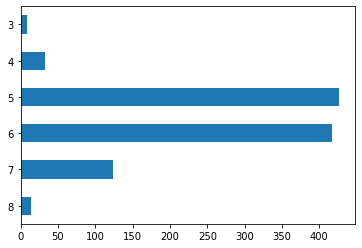

8     14
7    124
6    417
5    427
4     33
3      8
Name: class, dtype: int64


In [64]:
# show y distribution in plot and table
n = y['class'].value_counts().sort_index(ascending=False).plot(kind='barh')
plt.show()
n_table = y['class'].value_counts().sort_index(ascending=False)
print(n_table)

# n_table.to_excel(r'/content/data_evaluation\y-counts.xlsx', index=False)

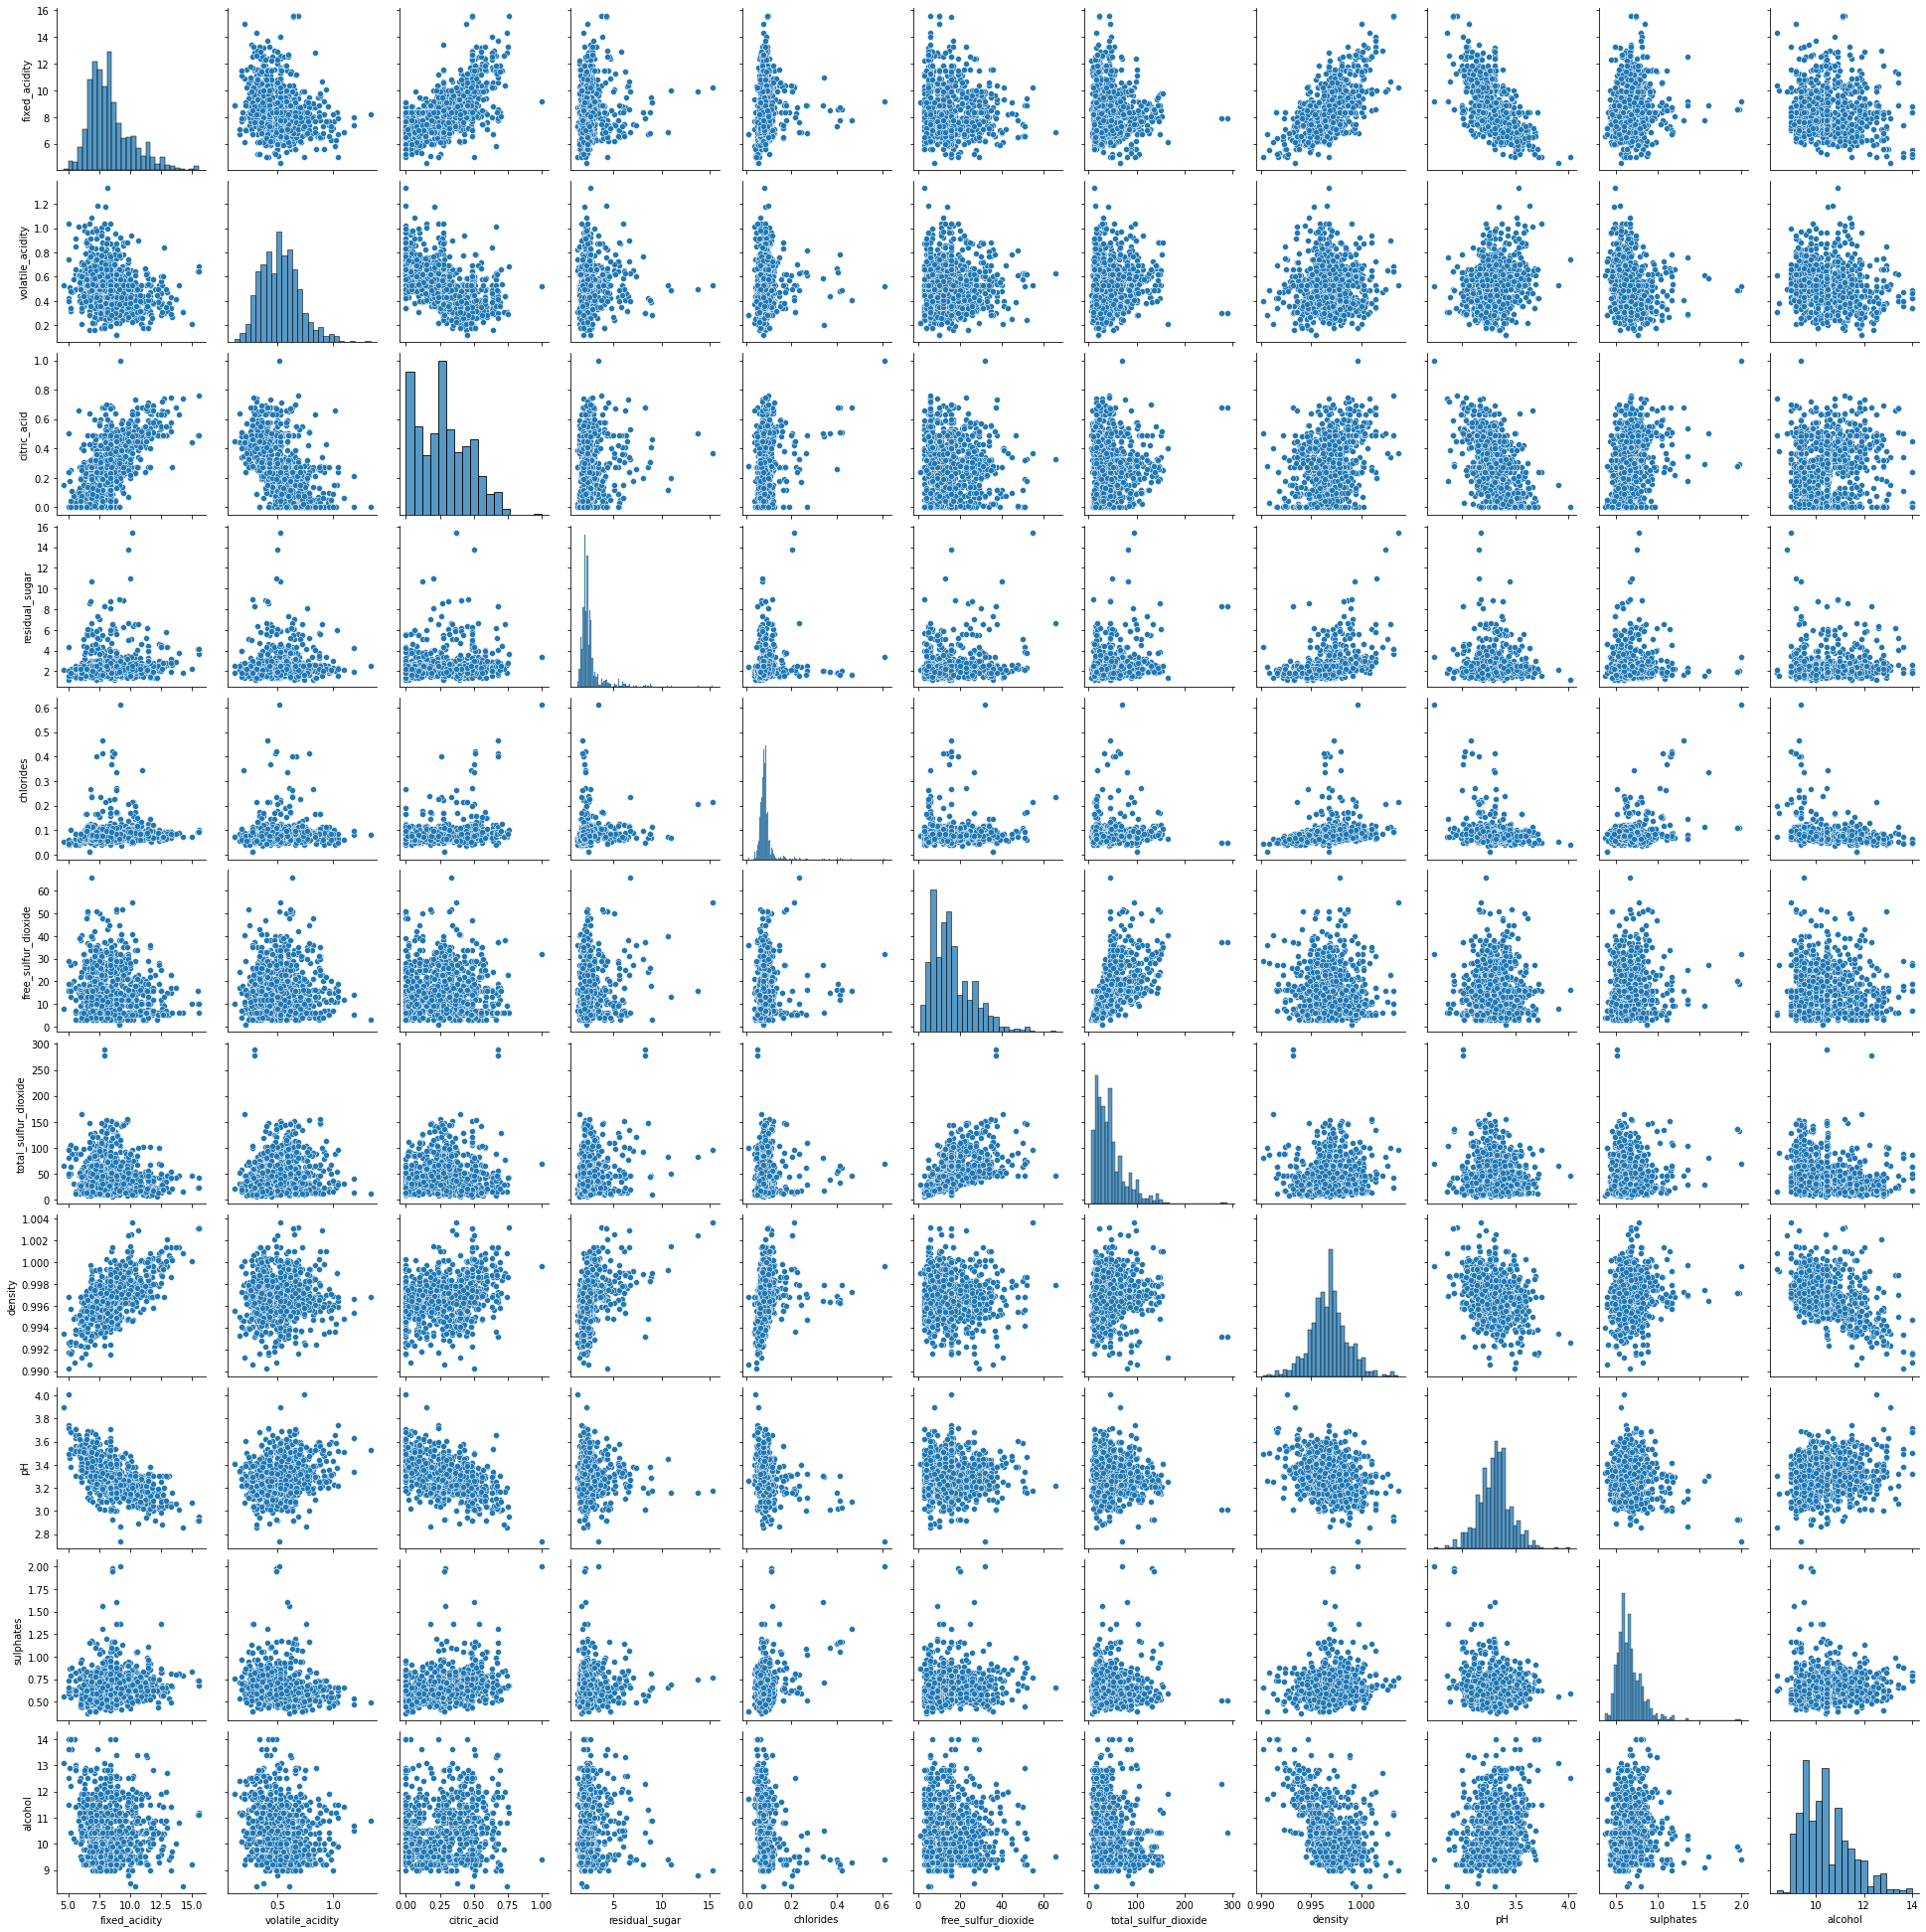

In [65]:
if type(X) != pd.DataFrame:
  X = pd.DataFrame(X)

sns.pairplot(X)
plt.show()
# plt.savefig('/content/ml_dataset')

column : 0


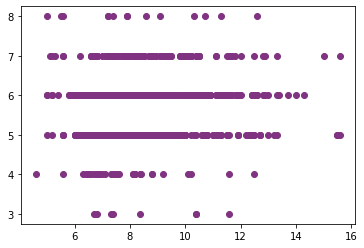

column : 1


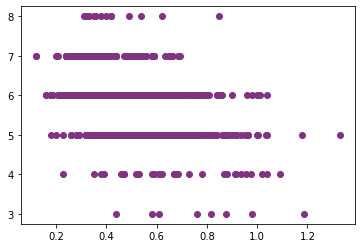

column : 2


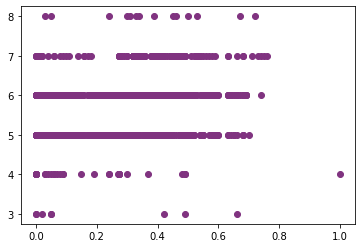

column : 3


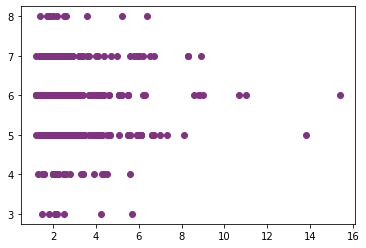

column : 4


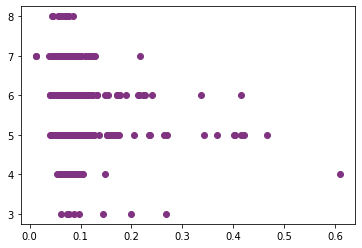

column : 5


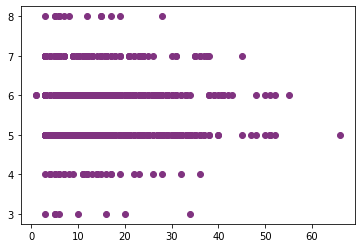

column : 6


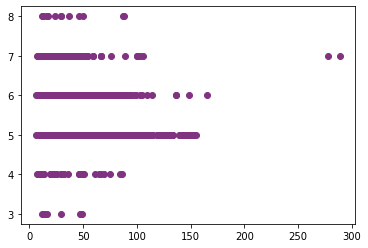

column : 7


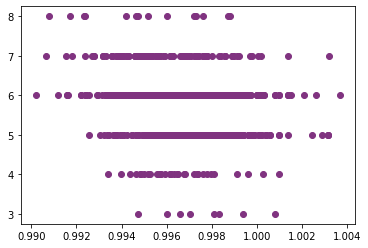

column : 8


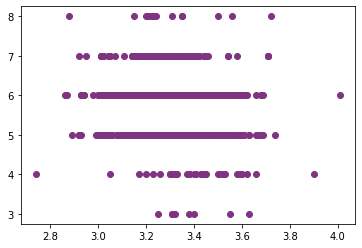

column : 9


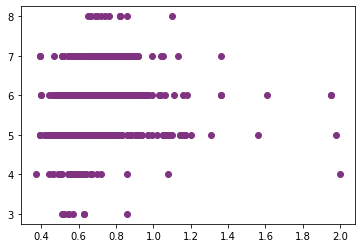

column : 10


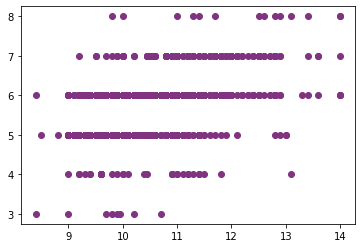

In [66]:
if type(X) != np.ndarray:
  X = X.to_numpy()
if type(y) != np.ndarray:
  y = y.to_numpy()
  y = y.flatten()
  
# show every x feature distribution in plot
for i in range(11):
  print("column : ", end = '')
  print(i)
  plt.scatter(X[:,i], y, color=(0.5,0.2,0.5))
  plt.show()

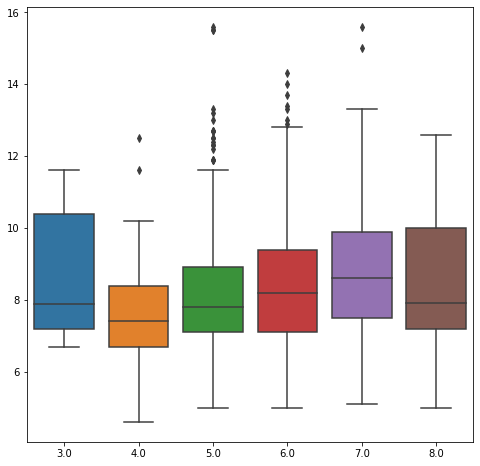

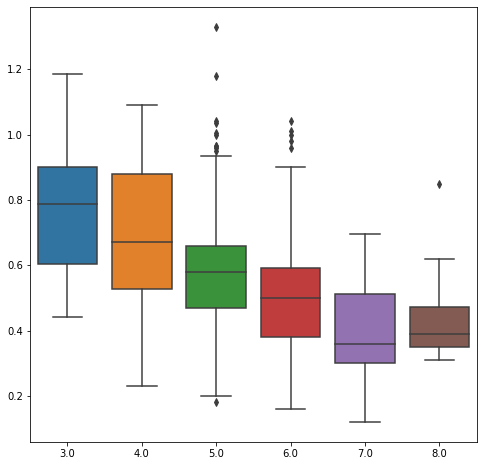

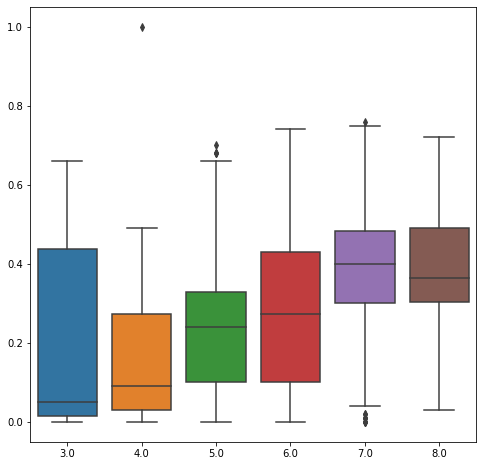

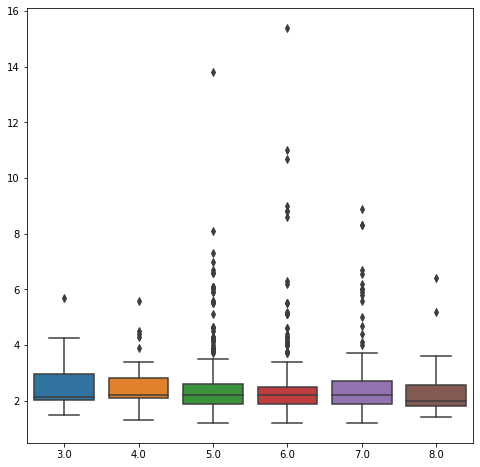

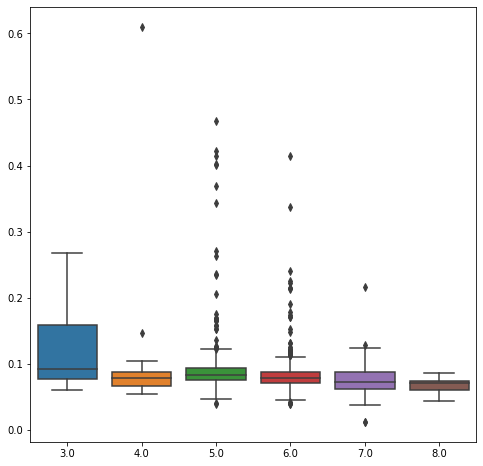

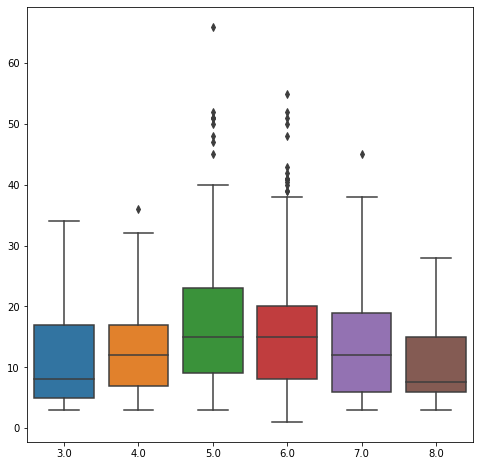

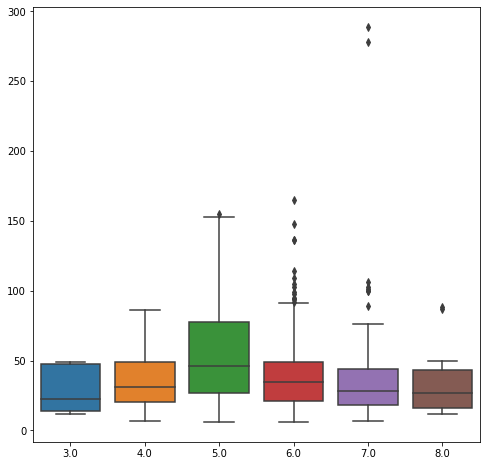

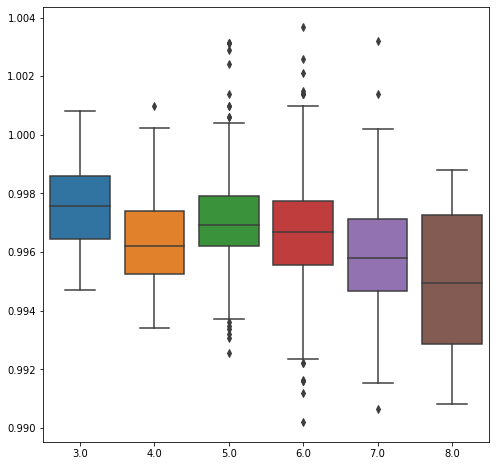

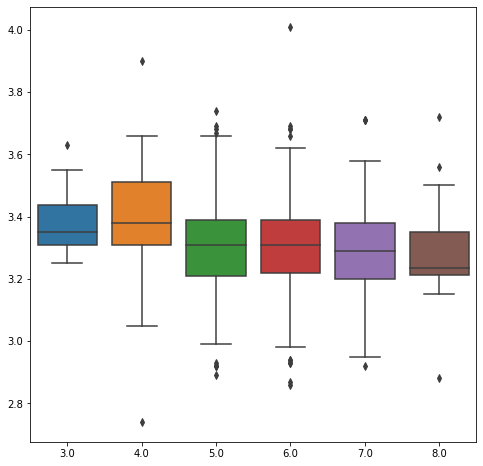

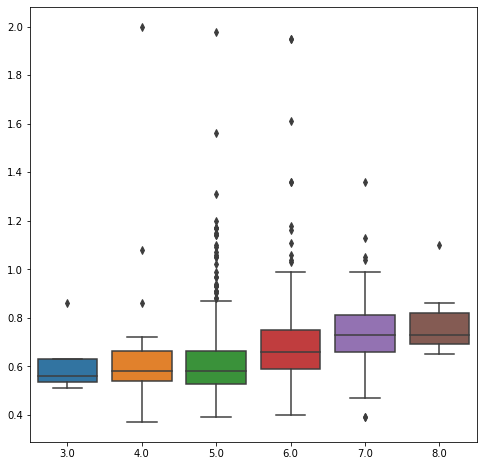

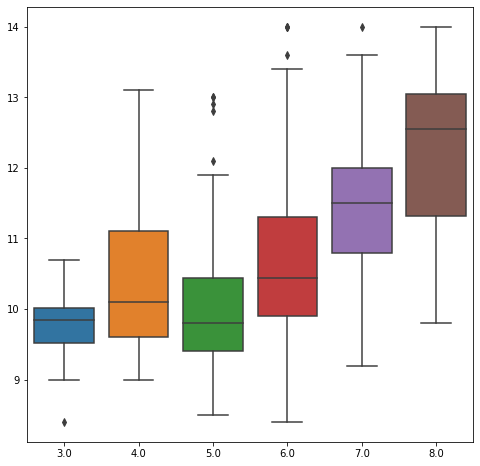

In [67]:
# Add a column with the class labels to the data
X_and_y = np.column_stack((X, y))

num_of_feature = X_and_y.shape[1] - 1

for i in range(num_of_feature):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.boxplot(x=X_and_y[:, -1], y=X_and_y[:, i], ax=ax)

# Show the plot
plt.show()

### Split, Feature select, Outlier, Oversample

In [68]:
if type(X) != np.ndarray:
  X = X.to_numpy()
if type(y) != np.ndarray:
  y = y.to_numpy()
  y = y.flatten()

**Change below cell if don't want validation**

In [69]:
# validation
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified shuffle split object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)

# Split the data into training and test sets
for train_index, val_index in strat_split.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

# no validation, only test
"""
X_train = X
y_train = y
X_val = np.zeros((X_train.shape[1],))
X_val = [X_val]
y_val = [0]

X_val
"""

'\nX_train = X\ny_train = y\nX_val = np.zeros((X_train.shape[1],))\nX_val = [X_val]\ny_val = [0]\n\nX_val\n'

Deal with outlier

In [70]:
# Compute the Z-scores (z = (x - mean) / std) of each feature and take absolute
z = np.abs(stats.zscore(X_train))

# Find the rows with features that have a Z-score greater than 4.5
outliers = np.where(z > 4.5)

# Print the outlier rows
print(outliers)

# Create a mask of the outliers
mask = np.ones(X_train.shape[0], dtype=bool)
mask[outliers[0]] = False

# Delete the outliers
X_train = X_train[mask, :]
y_train = y_train[mask]

(array([  6,  30,  57,  64,  98,  98, 105, 127, 413, 438, 445, 465, 465,
       492, 566, 574, 617, 691, 711, 728, 728, 737, 745, 758, 803, 817,
       817]), array([5, 3, 4, 1, 3, 6, 9, 4, 9, 9, 3, 4, 9, 4, 9, 3, 3, 4, 3, 3, 6, 4,
       3, 4, 4, 4, 9]))


Feature selection using  chi-square

In [71]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# Create a feature selector
selector = SelectKBest(chi2, k=7)

# Fit the selector to the data
selector.fit(X_train, y_train)

# Get the selected features
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)
X_test = selector.transform(X_test)

Over sampling in training data

In [72]:
"""
oversample = RandomOverSampler(sampling_strategy='auto')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
count_y_over = np.bincount(y_over)
print(count_y_over)
X_train = X_over
y_train = y_over
"""

"\noversample = RandomOverSampler(sampling_strategy='auto')\n# fit and apply the transform\nX_over, y_over = oversample.fit_resample(X_train, y_train)\ncount_y_over = np.bincount(y_over)\nprint(count_y_over)\nX_train = X_over\ny_train = y_over\n"

## Fit, test

### Evaluation functions

In [73]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [74]:
def confusionM(predictions, y_test):
  cm = confusion_matrix(y_test, predictions)

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(6)
  plt.xticks(tick_marks, [3, 4, 5, 6, 7, 8])
  plt.yticks(tick_marks, [3, 4, 5, 6, 7, 8])

  # Add labels and adjust plot parameters
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()

  # Display the plot
  plt.show()

In [75]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [76]:
def calculate_class_metrics(y_true, y_pred):
    labels = np.unique(y_true)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, average=None)

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, precision, width=bar_width, align='center', color=(0.5, 0.5, 1.0))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('precision Score')
    plt.show()

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, recall, width=bar_width, align='center', color=(0.95, 0.5, 0.95))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('recall Score')
    plt.show()

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, f1, width=bar_width, align='center', color=(0.1, 1.0, 1.0))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('F1 Score')
    plt.show()
    return precision, recall, f1

### Fit and evaluation

In [77]:
# print(X_train.shape)
# print(y_train.shape)

clf = tree(min_dataset_number = 4, max_depth = 100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
predictions_test = clf.predict(X_test)

acc = accuracy(y_val, predictions)
print(acc)

0.5658536585365853


[[ 0  0  2  0  0  0]
 [ 0  1  5  0  1  0]
 [ 0  3 55 24  2  1]
 [ 1  0 31 46  5  0]
 [ 0  0  4  6 14  1]
 [ 0  0  0  2  1  0]]


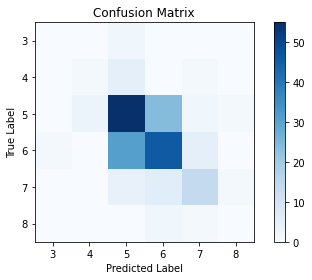

In [78]:
confusionM(predictions, y_val)

In [79]:
report(predictions, y_val)

Accuracy: 0.5658536585365853
Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.25      0.14      0.18         7
           5       0.57      0.65      0.60        85
           6       0.59      0.55      0.57        83
           7       0.61      0.56      0.58        25
           8       0.00      0.00      0.00         3

    accuracy                           0.57       205
   macro avg       0.34      0.32      0.32       205
weighted avg       0.56      0.57      0.56       205



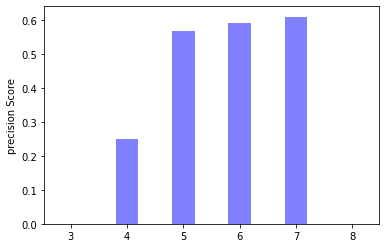

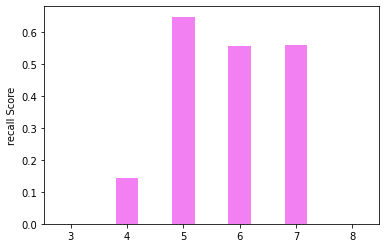

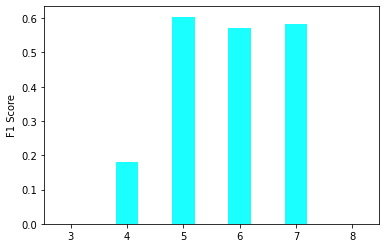

In [80]:
precision, recall, f1 = calculate_class_metrics(y_val, predictions)

[5 6 5 6 5 5 6 5 5 6 6 5 5 5 6 6 5 5 7 5 6 5 5 7 5 6 5 6 6 7 6 4 5 7 5 5 6
 6 5 5 5 6 5 4 6 5 5 5 7 5 5 5 5 5 7 6 6 5 6 6 6 5 6 5 5 5 5 6 6 6 6 4 7 6
 5 5 6 7 5 5 7 6 5 6 7 7 5 5 6 5 5 6 5 5 6 5 5 5 4 5 5 5 6 5 5 4 5 5 5 6 6
 5 7 5 5 5 7 5 6 5 5 6 5 6 5 5 5 5 6 5 7 5 5 5 5 5 5 5 5 5 6 5 6 6 6 5 7 6
 5 5 7 6 6 7 5 5 5 5 5 5 5 7 5 6 6 5 5 6 5 7 6 5 6 6 5 5 7 5 7 4 7 5 5 5 6
 5 5 5 5 7 5 6 5 6 5 5 5 7 6 5 6 6 6 3 5 7 4 5 6 6 5 8 5 6 5 7 5 6 6 6 6 5
 6 5 6 6 6 8 7 5 5 6 5 5 5 6 6 5 6 4 6 4 5 6 6 6 5 5 7 7 6 5 5 5 5 5]


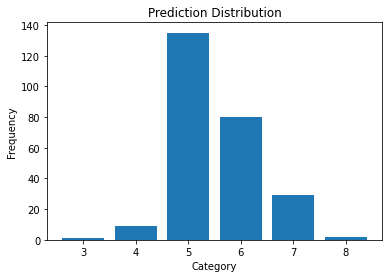

In [81]:
# test prediction distribution
print(predictions_test)
categories, counts = np.unique(predictions_test, return_counts=True)

# Create a bar plot of the predictions
plt.bar(categories, counts)

# Add a title and x- and y-axis labels
plt.title("Prediction Distribution")
plt.xlabel("Category")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [82]:
predictions_test = pd.DataFrame(predictions_test)
predictions_test.to_excel(r'/content/y_test1.xlsx', index=False)

# Movie review dataset

TA can directly run "**Tree**", "**Preprocessing**" cell.
Then pick to run either "**Way 1**" or "**Way 2**" cell.
Finally run "**Fit, test**" cell to see result for 2:8 validation: train performance.

## Tree

In [32]:
import numpy as np
from collections import Counter

# each node contain: feature and threshold used for the split, right and left child, leaf node has a label value
class node:
  def __init__(self, feature = None, thres = None, left_child = None, right_child = None, label = None):
    self.feature = feature
    self.thres = thres
    self.left_child = left_child
    self.right_child = right_child
    self.label = label

class tree:
  def __init__(self, min_dataset_number = 1, max_depth = 100,feature_num = None, root = None):
    self.min_dataset_number = min_dataset_number
    self.max_depth = max_depth
    self.feature_num = feature_num
    self.root = root 

  def fit(self, X, y): # function to run mainloop
    self.feature_number = X.shape[1] # define tree feature number
    self.root = self._main_loop(X, y) # define thhe "root" root
  
  def _main_loop(self, X, y, depth = 0): # main tree building function
    dataset_size, feature_size = X.shape
    unique_y = len(np.unique(y))

    # if (1) data set is smaller than min requirement
    # or (2) depth is equal to limit
    # (3) there's only one y value in all the leaves
    if (dataset_size < self.min_dataset_number or depth >= self.max_depth or unique_y == 1):
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)
    
    # find the best IG
    best_feature, best_thres, IG = self._best_split(X, y)

    # if there's no IG, stop training, return
    if IG == 0:
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)

    # seperate indices which belong to the left and right child
    left_idxs = np.argwhere(X[:, best_feature] <= best_thres).flatten()
    right_idxs = np.argwhere(X[:, best_feature] > best_thres).flatten()

    # if either child is empty, return
    if len(left_idxs) == 0 or len(right_idxs) == 0:
      counter = Counter(y)
      leaf_most_label = counter.most_common(1)[0][0] # return the most common "1", and return the class of it
      return node(label=leaf_most_label)  

    left = self._main_loop(X[left_idxs, :], y[left_idxs], depth+1)
    right = self._main_loop(X[right_idxs, :], y[right_idxs], depth+1)
    return node(best_feature, best_thres, left, right)

  def _best_split(self, X, y):
    max_gain = -10
    split_feature = None
    split_thres = None
    dataset_size, feature_size = X.shape

    # search best ig from the first feature to the last feature
    feature = 0 
    for feature in range(feature_size):
      col = X[:,feature]
      
      # search best ig inside a feature with different threshold
      uni_val_features = np.unique(col)
      for feature_val in uni_val_features:
        gain = self._ig(y, col, feature_val)
        
        if gain > max_gain:
          split_feature = feature
          split_thres = feature_val
          max_gain = gain
    IG = max_gain
    return split_feature, split_thres, IG


  def _ig(self, y, X_column, threshold):
    # (1) parent entropy
    occurs = np.bincount(y)
    occurance = occurs / len(y)
    self_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0])

    # pretend to create children
    left_dataset_ids = np.argwhere(X_column <= threshold).flatten()
    right_dataset_ids = np.argwhere(X_column > threshold).flatten()

    # (2) calculate the weighted avg. entropy of children
    n = len(y)
    left_child_size, right_child_size = len(left_dataset_ids), len(right_dataset_ids)

    if left_child_size != 0:
      occurs = np.bincount(y[left_dataset_ids])
      occurance = occurs / len(y[left_dataset_ids])
      left_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0])
    else:
      left_entropy = 0
    if right_child_size != 0:
      occurs = np.bincount(y[right_dataset_ids])
      occurance = occurs / len(y[right_dataset_ids])
      right_entropy = -np.sum([p * np.log(p) for p in occurance if p != 0])
    else:
      right_entropy = 0

    child_entropy = (left_child_size/n) * left_entropy + (right_child_size/n) * right_entropy

    # (3) calculate the IG
    ig = self_entropy - child_entropy
    return ig

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])

  def _traverse_tree(self, x, node):
    if node.label is not None:
      return node.label

    if x[node.feature] <= node.thres:
      return self._traverse_tree(x, node.left_child)
    return self._traverse_tree(x, node.right_child)



## Preprocessing

### Import

In [33]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='bs4')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
def preprocess_data(df):
    reviews = []
    for raw in tqdm(df['Phrase']):
        text = BeautifulSoup(raw, 'lxml').get_text()
        only_text = re.sub('[^a-zA-Z]', ' ', text)
        words = word_tokenize(only_text.lower())
        stops = set(stopwords.words('english'))
        non_stopwords = [word for word in words if not word in stops]
        lemma_words = [lemmatizer.lemmatize(word) for word in non_stopwords]    
        reviews.append(lemma_words)
    return reviews

In [35]:
X = pd.read_excel('/content/ml_dataset/Dataset2_train/X_train.xlsx')
y = pd.read_excel('/content/ml_dataset/Dataset2_train/y_train.xlsx')
X_test = pd.read_excel('/content/ml_dataset/Dataset2_train/X_test.xlsx')

In [36]:
X = X.fillna(X.mode())
X_test = X_test.fillna(X.mode())

train_text = preprocess_data(X)
target = y.values

X_test = preprocess_data(X_test)

100%|██████████| 31212/31212 [00:16<00:00, 1880.44it/s]


In [37]:
X = np.array(X)
y = np.array(y)
y = y.flatten()

**Change the below cell if want to remove validation**

In [38]:
# validation
X_train, X_val, y_train, y_val = train_test_split(train_text, target, test_size=0.2, stratify=target)

# no validation, only test
# X_train, X_val, y_train, y_val = train_test_split(train_text, target, test_size=0.000035, stratify=target)

## Way 1. TA method

In [79]:
def tokenizer_preprocess(list_X_train, list_X_val, list_X_test):
    unique_words = set()
    len_max = 0
    for sent in tqdm(list_X_train):
        unique_words.update(sent)
        if len_max < len(sent):
            len_max = len(sent)
    len(list(unique_words)), len_max

    tokenizer = Tokenizer(num_words=len(list(unique_words)))
    tokenizer.fit_on_texts(list(list_X_train))
     
    X_train = tokenizer.texts_to_sequences(list_X_train)
    X_train = pad_sequences(X_train, maxlen=len_max)

    X_val = tokenizer.texts_to_sequences(list_X_val)
    X_val = pad_sequences(X_val, maxlen=len_max)

    X_test = tokenizer.texts_to_sequences(list_X_test)
    X_test = pad_sequences(X_test, maxlen=len_max)

    return X_train, X_val, X_test

In [80]:
X_TRAIN, X_VAL, X_TEST = tokenizer_preprocess(X_train, X_val, X_test)  

100%|██████████| 124843/124843 [00:00<00:00, 857196.29it/s]


In [81]:
X_TRAIN, X_VAL, X_TEST

(array([[    0,     0,     0, ...,  7636,  1323,  6171],
        [    0,     0,     0, ...,     0,   111,    80],
        [    0,     0,     0, ...,   157,  9878,     8],
        ...,
        [    0,     0,     0, ...,  1528,   332,  2752],
        [    0,     0,     0, ...,     0, 12939,  1098],
        [    0,     0,     0, ...,     0,     0,  2957]], dtype=int32),
 array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0, 8192],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  344, 1966,  493,  183, 1299],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,  312,  508,  878, 2019,  960,  120],
      

## Way 2. Bagging


把所有出現過一定次數的字當成一個feature

In [39]:
import copy

# fidn every unique word
training_bag = []
final_ft = []
for x in X_train:
  for token in x:
    training_bag.append(token)

# count every unique words' appearance
train_word_count = Counter(training_bag)
final_ft = copy.deepcopy(train_word_count)

# 每一個字，如果出現少於多少次，刪掉
for token in train_word_count:
  if train_word_count[token] < 150 or train_word_count[token] > 1600:
    del final_ft[token]
    
# keys = 最後剩下的字(feature)
keys = final_ft.keys()
num_feat = len(keys)
print("number of features: ", end='')
print(num_feat)
print("The features: ", end='')
print(final_ft.keys())


number of features: 410
The features: dict_keys(['emotion', 'funny', 'together', 'look', 'life', 'strong', 'sense', 'cast', 'going', 'past', 'even', 'little', 'anything', 'seen', 'american', 'right', 'direction', 'real', 'u', 'well', 'actually', 'crime', 'flick', 'spirit', 'nothing', 'play', 'acting', 'exercise', 'give', 'performance', 'world', 'something', 'yet', 'everything', 'girl', 'sometimes', 'portrait', 'melodrama', 'rather', 'impossible', 'action', 'run', 'idea', 'two', 'hard', 'cinema', 'find', 'new', 'scene', 'interesting', 'go', 'least', 'minute', 'fall', 'short', 'true', 'bad', 'plot', 'classic', 'drama', 'come', 'man', 'romance', 'comedy', 'dead', 'day', 'dream', 'young', 'trying', 'way', 'art', 'ever', 'hour', 'place', 'mystery', 'leave', 'eye', 'dark', 'john', 'next', 'line', 'heart', 'small', 'child', 'simply', 'familiar', 'need', 'self', 'people', 'make', 'never', 'old', 'clever', 'best', 'thing', 'amusing', 'boy', 'entertaining', 'rare', 'would', 'piece', 'french', 'w

In [40]:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_val)

<ipython-input-40-84582f5cb5b8>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
<ipython-input-40-84582f5cb5b8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val = np.array(X_val)


把每個把每個training轉成0 1，1代表某字有出現，代表某字有出現，0代表沒有

In [41]:
# if a feature word appear in x Train, mark the feature as 1, else 0
X_TRAIN = []
i = 0
for x in X_train:
  tmp = []
  for token in final_ft:
    token_occurrences = x.count(token)
    if token_occurrences != 0:
      tmp.append(1)
    else:
      tmp.append(0)
  #print(tmp)
  X_TRAIN.append(tmp)

把全零的句子從句子從training拿掉（減少後面處理負擔）

In [42]:
X_TRAIN = np.array(X_TRAIN)

all_zero_row = []
for i in range(X_TRAIN.shape[0]):
    #np.any detect if any of the feature is non-zero
    if not np.any(X_TRAIN[i,:]):
        all_zero_row.append(i)

# Delete the rows with all zero features
X_TRAIN = np.delete(X_TRAIN, all_zero_row, axis=0)
y_train = np.delete(y_train, all_zero_row, axis=0)

print(X_TRAIN.shape[0])
print(y_train.shape[0])

63289
63289


把每個把每個validation轉成0 1，1代表某字有出現，代表某字有出現，0代表沒有

In [43]:
X_VAL = []
for x in X_val:
  tmp = []
  for token in final_ft:
    token_occurrences = x.count(token)
    if token_occurrences != 0:
      tmp.append(1)
    else:
      tmp.append(0)
  #print(tmp)
  X_VAL.append(tmp)

print(X_VAL[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

把每個把每個testing轉成0 1，1代表某字有出現，代表某字有出現，0代表沒有

In [44]:
X_TEST = []
for x in X_test:
  tmp = []
  for token in final_ft:
    token_occurrences = x.count(token)
    if token_occurrences != 0:
      tmp.append(1)
    else:
      tmp.append(0)
  #print(tmp)
  X_TEST.append(tmp)

print(X_TEST[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Feature selection

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# Create a feature selector
selector = SelectKBest(chi2, k=200)

# Fit the selector to the data
selector.fit(X_TRAIN, y_train)

# Get the selected features
X_TRAIN = selector.transform(X_TRAIN)
X_VAL = selector.transform(X_VAL)
X_TEST = selector.transform(X_TEST)

把全零的句子從句子從training拿掉（減少後面處理負擔)

In [46]:
all_zero_row = []
for i in range(X_TRAIN.shape[0]):
    #np.any detect if any of the feature is non-zero
    if not np.any(X_TRAIN[i,:]):
        all_zero_row.append(i)

# Delete the rows with all zero features
X_TRAIN = np.delete(X_TRAIN, all_zero_row, axis=0)
y_train = np.delete(y_train, all_zero_row, axis=0)

print(X_TRAIN.shape[0])
print(y_train.shape[0])

46688
46688


## Fit, test

### Evaluation functions

In [47]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

In [48]:
def confusionM(predictions, y_test):
  cm = confusion_matrix(y_test, predictions)

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  tick_marks = np.arange(6)
  plt.xticks(tick_marks, [0, 1, 2, 3, 4])
  plt.yticks(tick_marks, [0, 1, 2, 3, 4])

  # Add labels and adjust plot parameters
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.tight_layout()

  # Display the plot
  plt.show()

In [49]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

In [50]:
def calculate_class_metrics(y_true, y_pred):
    labels = np.unique(y_true)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels, average=None)

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, precision, width=bar_width, align='center', color=(0.5, 0.5, 1.0))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('precision Score')
    plt.show()

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, recall, width=bar_width, align='center', color=(0.95, 0.5, 0.95))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('recall Score')
    plt.show()

    class_labels = np.unique(y_val)
    bar_width = 0.4
    x_pos = np.arange(len(class_labels))
    plt.bar(x_pos, f1, width=bar_width, align='center', color=(0.1, 1.0, 1.0))
    plt.xticks(x_pos, class_labels)
    plt.ylabel('F1 Score')
    plt.show()
    return precision, recall, f1

### Fit and Evaluation

In [51]:
y_train = y_train.flatten()
y_val = y_val.flatten()

clf = tree(min_dataset_number = 5, max_depth = 100)
clf.fit(X_TRAIN, y_train) 
predictions = clf.predict(X_VAL)
predictions_test = clf.predict(X_TEST)

print(y_val)
print(predictions)

[2 1 1 ... 2 2 3]
[3 1 1 ... 2 2 2]


In [52]:
acc = accuracy(y_val, predictions)
print("Accuracy: ")
print(acc)

Accuracy: 
0.5629955947136563


[[  118   176   778    55     5]
 [  120   551  3491   191    11]
 [   34   268 11775   631    25]
 [    7    95  3612  1372   182]
 [    1    17   722   491   242]]


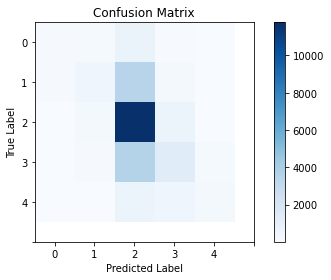

In [53]:
confusionM(predictions, y_val)

In [54]:
report(predictions, y_val)

Accuracy: 0.5629955947136563
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.10      0.17      1132
           1       0.50      0.13      0.20      4364
           2       0.58      0.92      0.71     12733
           3       0.50      0.26      0.34      5268
           4       0.52      0.16      0.25      1473

    accuracy                           0.56     24970
   macro avg       0.50      0.32      0.33     24970
weighted avg       0.54      0.56      0.49     24970



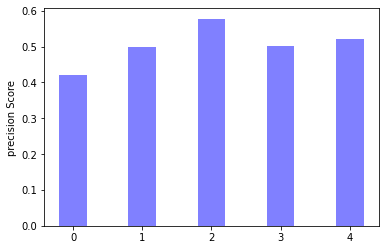

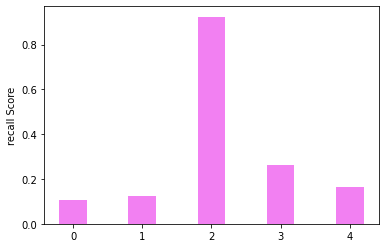

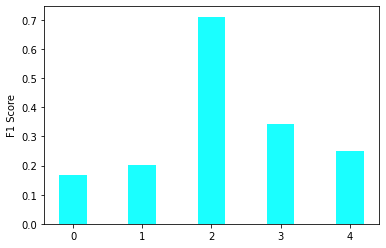

In [55]:
precision, recall, f1 = calculate_class_metrics(y_val, predictions)

[2 2 2 ... 2 2 2]


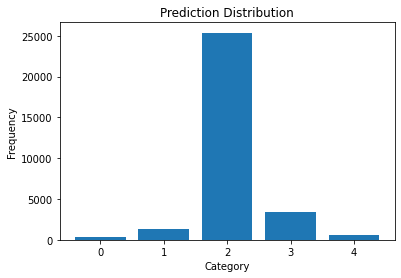

In [56]:
# test prediction distribution
print(predictions_test)
categories, counts = np.unique(predictions_test, return_counts=True)

# Create a bar plot of the predictions
plt.bar(categories, counts)

# Add a title and x- and y-axis labels
plt.title("Prediction Distribution")
plt.xlabel("Category")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [57]:
predictions_test = pd.DataFrame(predictions_test)
predictions_test.to_excel(r'/content/y_test2.xlsx', index=False)